<a href="https://colab.research.google.com/github/taitip-supha/DeepLearn-Keras/blob/main/04_AutoEncoder/AVE_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Prepar the Enviroment

In [ ]:
# List all NVIDIA GPUs as avaiable in this computer (or colub's session)
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
#Import package
import sys,os,time,datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
%matplotlib inline
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Tensorflow detected : {len(gpus)} GPU(s)")
for i,gpu in enumerate(gpus):
  print(f" GPU No. {i} : Name = {gpu.name} , Type = {gpu.device_type}")


Python 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
NumPy 1.21.5
tf.keras.backend.image_data_format() = channels_last
Tensorflow detected : 0 GPU(s)


In [ ]:
#Set Disable eager execution
from tensorflow.python.framework.ops import disable_eager_execution
# Since TF 2.x, eager mode is enabled by default
print( f"Before : TF executing eagerly : {tf.executing_eagerly()}")
if tf.executing_eagerly():
   disable_eager_execution()

print( f"After : TF executing eagerly : {tf.executing_eagerly()}")

Before : TF executing eagerly : True
After : TF executing eagerly : False


In [ ]:
#Set fixed seeding values for reproducability during experiments
#to guarantee reproducability, make sure valuesfor any randomize poperation are all set
np.random.seed(1234)
tf.random.set_seed(5678)

# 1 Prepare the Fashion MNIST dataset

In [ ]:
#Ref : https://keras.io/api/datasets/fashion_mnist/
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# Inspect MNIST dataset
print( f"Training set: x_train = {x_train.shape}, y_train = {y_train.shape}")
print( f"Testing  set: x_test  = {x_test.shape},  y_test  = {y_test.shape}")

Training set: x_train = (60000, 28, 28), y_train = (60000,)
Testing  set: x_test  = (10000, 28, 28),  y_test  = (10000,)


In [ ]:
dicFashion= { 0:"T-shirt/top", 1 :	"Trouser", 2 :	"Pullover", 3 :	"Dress", 4 :	"Coat", 5 :	"Sandal", 6 :	"Shirt", 7 :	"Sneaker", 8 :	"Bag", 9 :	"Ankle boot"}

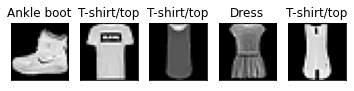

In [ ]:
#Plot the first five image in x_train
for i in range(5):
   plt.subplot(150+1+i).set_title(dicFashion[y_train[i]])
   plt.imshow( x_train[i] ,cmap=plt.get_cmap('gray'))
   plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

In [ ]:
#Covert each pixel from unsigned int 8-bit (0-255) data type to 32-bit floating point data type
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [ ]:
# Input normalization from 0-255 to 0.0 - 1.0
x_train /= 255
x_test /= 255

In [ ]:
# Reshape to (batch_size, H, W, Channel)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print( f"New x_train shape = {x_train.shape}")
print( f"New x_test  shape = {x_test.shape} ")

New x_train shape = (60000, 28, 28, 1)
New x_test  shape = (10000, 28, 28, 1) 


# 2 Create the network architecture

### >> Create Sampling Layer

In [ ]:
class Sampling( tf.keras.layers.Layer ):
  """
  code from https://keras.io/examples/generative/vae/
  Reparameterization trick by sampling from an isotropic unit Gaussian.
  Instead of sampling from Q(z|X), we sample from epsilon = N(0,I).
  z = z_mean + sqrt(var) * epsilon, when z is an encoded latent vector
  """
  def call(self, inputs ):
    z_mean, z_logvar = inputs
    batch_size = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal( shape=(batch_size,dim) )
    return z_mean+tf.exp(0.5 * z_logvar)*epsilon

### >> Encoder

In [ ]:
latent_dim=100

in_img = tf.keras.layers.Input( shape=(28,28,1), name='input_img')
x = tf.keras.layers.Dropout(0.2, name='encoder_Dropout')(in_img)

#Encoder
x = tf.keras.layers.Conv2D( 32, (3,3), activation='relu', padding='same'            ,name='encoder_CNN01')(x)
x = tf.keras.layers.Conv2D( 32, (3,3), activation='relu', padding='same', strides=2 ,name='encoder_CNN02')(x)
x = tf.keras.layers.Conv2D( 64, (3,3), activation='relu', padding='same', strides=2 ,name='encoder_CNN03')(x)
x = tf.keras.layers.BatchNormalization(axis=-1, name='encoder_batchnorm')(x)

x = tf.keras.layers.Flatten(name='encoder_flatten')(x)

#### Bottlenneck ####
z_mean = tf.keras.layers.Dense( latent_dim, name='z_mean')(x)
z_logvar = tf.keras.layers.Dense( latent_dim, name='z_logvar')(x)

# Use reparameterization trick to push the simpling 
z = Sampling(name='z_sampling')([z_mean,z_logvar])

#Instantiate the encoder model
encoder = tf.keras.models.Model( in_img, [z_mean, z_logvar, z], name='encoder')
encoder.summary()


Instructions for updating:
Colocations handled automatically by placer.
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_Dropout (Dropout)      (None, 28, 28, 1)    0           ['input_img[0][0]']              
                                                                                                  
 encoder_CNN01 (Conv2D)         (None, 28, 28, 32)   320         ['encoder_Dropout[0][0]']        
                                                                                                  
 encoder_CNN02 (Conv2D)         (None, 14, 14, 32)   9248        ['encoder_CNN01[0][0]']          
                    

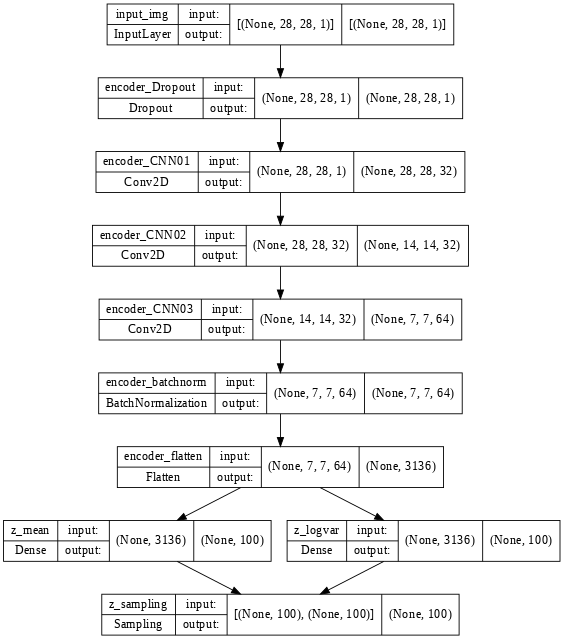

In [ ]:
tf.keras.utils.plot_model(encoder, "VAE_Encoder.png", show_shapes=True, show_layer_names=True ,dpi=64)

###>> Decoder

In [ ]:
#### Decoder ####
latent_inputs = tf.keras.layers.Input( shape=(latent_dim,), name='latent_sampling') #Output : (None, 2)

x = tf.keras.layers.Dense( 7*7*64 ,activation='relu', name='decoder_dense')(latent_inputs)  
x = tf.keras.layers.Reshape( (7,7,64), name='decoder_rehape' )(x)

x = tf.keras.layers.BatchNormalization(axis=-1, name='decoder_batchnorm')(x)
x = tf.keras.layers.Conv2DTranspose( 64, (3,3), activation='relu', padding='same', strides=2, name='decoder_CNN0T1')(x)
x = tf.keras.layers.Conv2DTranspose( 32, (3,3), activation='relu', padding='same', strides=2, name='decoder_CNN0T2')(x)
x = tf.keras.layers.Conv2DTranspose( 32, (3,3), activation='relu', padding='same'           , name='decoder_CNN0T3')(x)


#output
out_img = tf.keras.layers.Conv2DTranspose( 1, (3,3), activation='sigmoid', padding='same', name='output_img')(x)

# Instantiate the decoder model
decoder = tf.keras.models.Model( latent_inputs, out_img, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_sampling (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 decoder_dense (Dense)       (None, 3136)              316736    
                                                                 
 decoder_rehape (Reshape)    (None, 7, 7, 64)          0         
                                                                 
 decoder_batchnorm (BatchNor  (None, 7, 7, 64)         256       
 malization)                                                     
                                                                 
 decoder_CNN0T1 (Conv2DTrans  (None, 14, 14, 64)       36928     
 pose)                                                           
                                                           

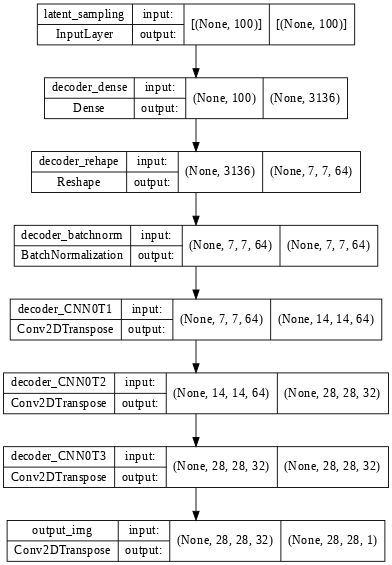

In [ ]:
tf.keras.utils.plot_model(decoder, "VAE_Decoder.png", show_shapes=True, show_layer_names=True ,dpi=64)

###>> Construct VAE Model

In [ ]:
# Amoung the thee output of encoder, send only the last one (=z) to decoder
vae_out = decoder( encoder(in_img)[2] )

#Instantiate AVE model
vae = tf.keras.models.Model( in_img, vae_out, name='vae_cnn_model' )
vae.summary()

Model: "vae_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 100),             655720    
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         381921    
                                                                 
Total params: 1,037,641
Trainable params: 1,037,385
Non-trainable params: 256
_________________________________________________________________


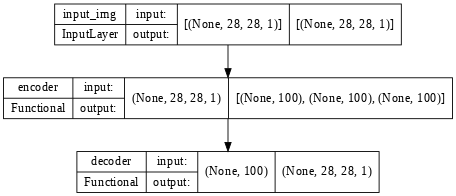

In [ ]:
tf.keras.utils.plot_model(vae, "VAE_CNN_model.png", show_shapes=True, show_layer_names=True ,dpi=64)

# 3 Compile and Train the model

### >> Compile the model

In [ ]:
def vae_loss( y_true, y_pred ):
   #Original reconstruction loss choose one from two lines below
   recon_loss = tf.keras.backend.square( y_pred-y_true )
   recon_loss =  tf.keras.backend.mean(recon_loss, axis=None)
   recon_loss = tf.keras.backend.sqrt(recon_loss)
   #recon_loss = tf.keras.losses.binary_crossentropy( y_true, y_pred)
   # Extract two output vectors from the 'encoder'
   z_mean = vae.get_layer('encoder').get_layer('z_mean').output
   z_logvar = vae.get_layer('encoder').get_layer('z_logvar').output

   # latent loss
   latent_loss = 1 + z_logvar - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_logvar)
   latent_loss = tf.keras.backend.sum( latent_loss, axis=None ) 
   latent_loss *= -0.5

   return tf.keras.backend.mean( (recon_loss * 784 *100) + latent_loss )

In [ ]:
vae.compile( optimizer='rmsprop', loss=vae_loss, metrics=["acc"] )

### >> Create a custom callback

In [ ]:
my_history = dict()
class GenerativeModel_Eval( tf.keras.callbacks.Callback ):
  def __init__(self ,epochs, n=5) :
     """ 
     Arguments:
       epochs(int) : how many epochs to train the model
       n (int) : evaluate the model once for every 'n' epoch passed
     """
     super(GenerativeModel_Eval, self).__init__()
     self.__epochs = epochs
     self.__n = n if n>0 else 5

  def on_epoch_begin( self, epoch, logs=None):
     if epoch % self.__n == 0:
       self.__predict_with_current_model( epoch )

  def on_train_end( self, logs=None):
     for k,v in self.model.history.history.items():
       my_history[k] = v.copy()
     self.__predict_with_current_model( self.__epochs)
  
  def __predict_with_current_model(self, current_epoch, n_samples=6):
     """ 
     Argument:
       current_epoch (int) : the number of current epoch
       n_sample (int) : evaluate the first 'n_sample' samples in the test set """
    
     #Use the current model to predict x_test[0] - x_test[n-cols-1]
     n_cols = n_samples
     n_rows = 2

     #Prepare 2-row of image (each row contains n_cols images)
     fig_h =5
     fig, axes = plt.subplots( n_rows, n_cols, figsize=( (fig_h * n_cols) // n_rows, fig_h) )
     fig.suptitle( f"******** Model after being train for {current_epoch} epochs" )
     for i in range(n_cols):
        x_recon = self.model.predict( np.array( [x_test[i] ] ) )

        # First row is original x_test image
        axes[0, i].set_title( f" x_test[{i}] = {y_test[i] }" )
        axes[0, i].imshow( x_test[i].reshape(28,28), cmap=plt.get_cmap('gray') )

        # Second row is the reconstructed image by auto encoder
        axes[1, i].imshow( x_recon.reshape(28, 28), cmap=plt.get_cmap('gray') )

     plt.show()


###>> Train the model

Train on 60000 samples, validate on 10000 samples


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


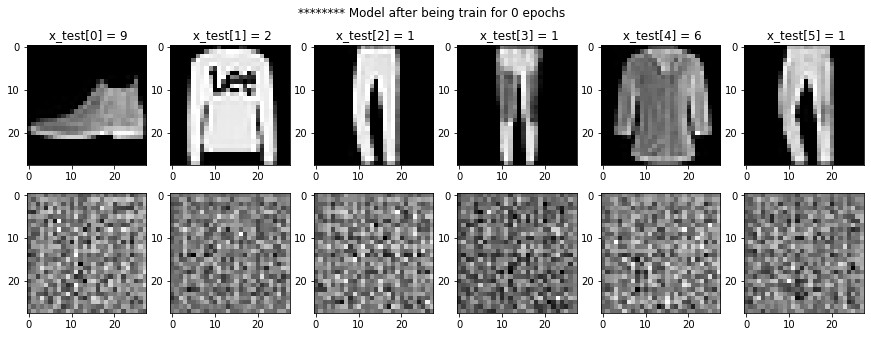

Epoch 1/20
60000/60000 [==============================] - ETA: 0s - loss: 15873.4707 - acc: 0.5001

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 295s 5ms/sample - loss: 15873.4707 - acc: 0.5001 - val_loss: 14753.5069 - val_acc: 0.5038
Epoch 2/20
60000/60000 [==============================] - 293s 5ms/sample - loss: 13519.7681 - acc: 0.5047 - val_loss: 13303.4447 - val_acc: 0.5035
Epoch 3/20
60000/60000 [==============================] - 293s 5ms/sample - loss: 12923.8751 - acc: 0.5057 - val_loss: 12953.8598 - val_acc: 0.5048
Epoch 4/20
60000/60000 [==============================] - 293s 5ms/sample - loss: 12617.3471 - acc: 0.5061 - val_loss: 12748.0063 - val_acc: 0.5048
Epoch 5/20
60000/60000 [==============================] - 294s 5ms/sample - loss: 12436.6890 - acc: 0.5064 - val_loss: 13819.2091 - val_acc: 0.5055


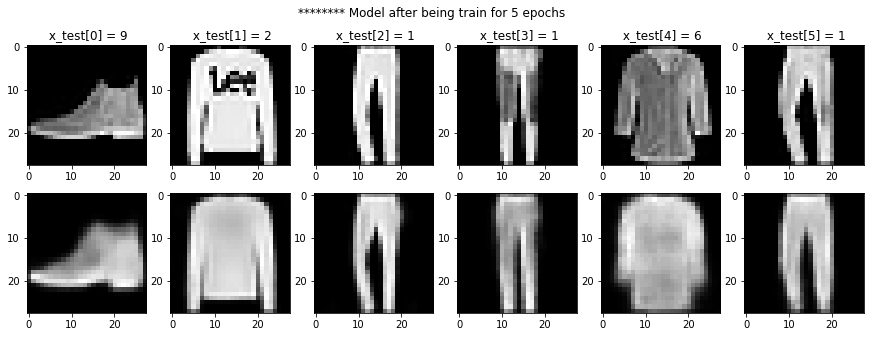

Epoch 6/20
60000/60000 [==============================] - 291s 5ms/sample - loss: 12295.9477 - acc: 0.5066 - val_loss: 13401.5718 - val_acc: 0.5054
Epoch 7/20
60000/60000 [==============================] - 291s 5ms/sample - loss: 12191.8312 - acc: 0.5067 - val_loss: 13736.3456 - val_acc: 0.5056
Epoch 8/20
60000/60000 [==============================] - 291s 5ms/sample - loss: 12120.2865 - acc: 0.5068 - val_loss: 12752.0143 - val_acc: 0.5053
Epoch 9/20
60000/60000 [==============================] - 292s 5ms/sample - loss: 12041.3373 - acc: 0.5069 - val_loss: 12787.8062 - val_acc: 0.5057
Epoch 10/20
60000/60000 [==============================] - 291s 5ms/sample - loss: 11978.4081 - acc: 0.5070 - val_loss: 13270.0041 - val_acc: 0.5057


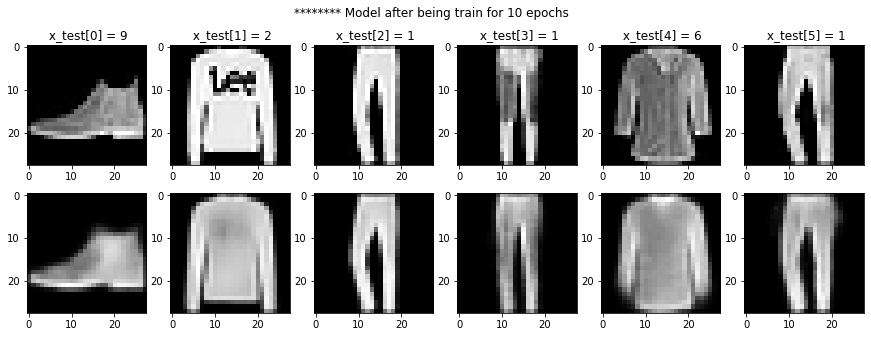

Epoch 11/20
60000/60000 [==============================] - 292s 5ms/sample - loss: 11931.6409 - acc: 0.5071 - val_loss: 11969.4457 - val_acc: 0.5052
Epoch 12/20
60000/60000 [==============================] - 307s 5ms/sample - loss: 11884.3602 - acc: 0.5071 - val_loss: 12283.3574 - val_acc: 0.5054
Epoch 13/20
60000/60000 [==============================] - 301s 5ms/sample - loss: 11847.8833 - acc: 0.5072 - val_loss: 12010.2702 - val_acc: 0.5050
Epoch 14/20
60000/60000 [==============================] - 296s 5ms/sample - loss: 11807.9106 - acc: 0.5073 - val_loss: 13381.0830 - val_acc: 0.5059
Epoch 15/20
60000/60000 [==============================] - 295s 5ms/sample - loss: 11780.4129 - acc: 0.5073 - val_loss: 11891.2923 - val_acc: 0.5044


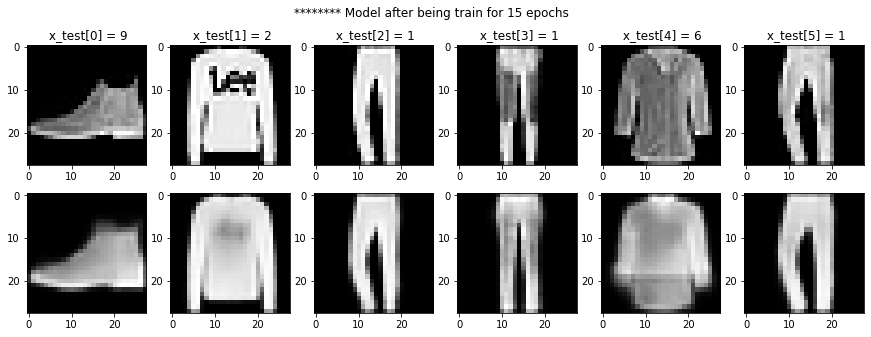

Epoch 16/20
60000/60000 [==============================] - 295s 5ms/sample - loss: 11756.3387 - acc: 0.5073 - val_loss: 12071.2398 - val_acc: 0.5039
Epoch 17/20
60000/60000 [==============================] - 295s 5ms/sample - loss: 11720.0231 - acc: 0.5073 - val_loss: 12663.8323 - val_acc: 0.5059
Epoch 18/20
60000/60000 [==============================] - 296s 5ms/sample - loss: 11692.9995 - acc: 0.5074 - val_loss: 12313.3681 - val_acc: 0.5055
Epoch 19/20
60000/60000 [==============================] - 295s 5ms/sample - loss: 11679.5689 - acc: 0.5074 - val_loss: 12201.9573 - val_acc: 0.5057
Epoch 20/20
60000/60000 [==============================] - 295s 5ms/sample - loss: 11655.2548 - acc: 0.5074 - val_loss: 12154.6497 - val_acc: 0.5056


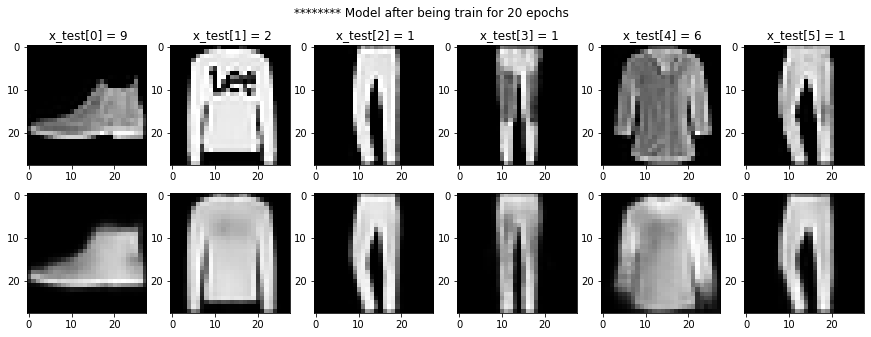

CPU times: user 2h 56min 52s, sys: 5min 8s, total: 3h 2min 1s
Wall time: 1h 38min 21s


In [ ]:
%%time
n_epochs = 20
ex3_hist = vae.fit( x_train, x_train, validation_data=(x_test, x_test), 
                   batch_size=128, epochs=n_epochs, verbose=1, callbacks=[GenerativeModel_Eval(n_epochs,5) ])

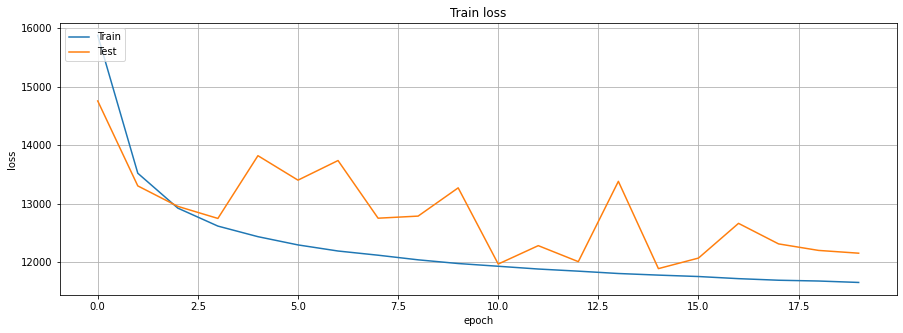

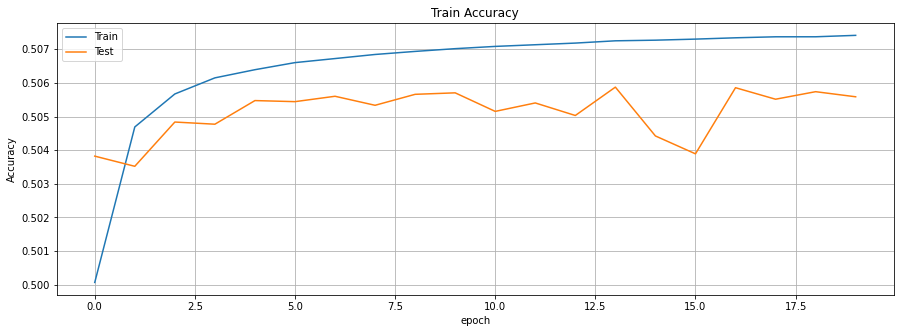

In [ ]:
# Summarize history for mean absolute error(mae)/Accuracy
if 'loss' in my_history.keys():
  plt.figure( figsize=(15,5) )
  plt.plot( my_history['loss'] )
  plt.plot( my_history['val_loss'] )
  plt.title( 'Train loss')
  plt.ylabel( 'loss')
  plt.xlabel('epoch')
  plt.legend( ['Train','Test'], loc='upper left')
  plt.grid()
  plt.show()
if 'acc' in my_history.keys():
  plt.figure( figsize=(15,5) )
  plt.plot( my_history['acc'] )
  plt.plot( my_history['val_acc'] )
  plt.title( 'Train Accuracy')
  plt.ylabel( 'Accuracy')
  plt.xlabel('epoch')
  plt.legend( ['Train','Test'], loc='upper left')
  plt.grid()
  plt.show()

In [ ]:
# Save Model
vae.save('/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/result/vae_fashionMNIST.h5')

# 4 Evaluate the model on test set

In [ ]:
ex3_result = vae.evaluate( x_test, x_test, batch_size=128)
print(f"{vae.metrics_names} = {ex3_result}")

['loss', 'acc'] = [12146.92315, 0.5055635]


# 5 Inference

##>> Generate from picture

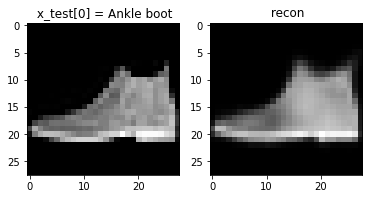

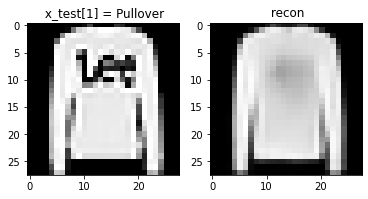

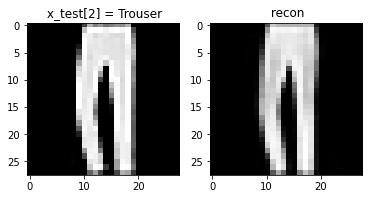

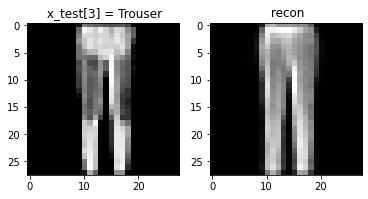

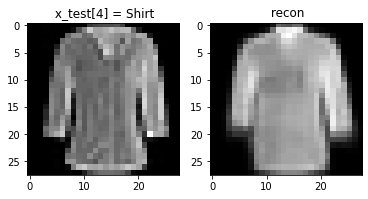

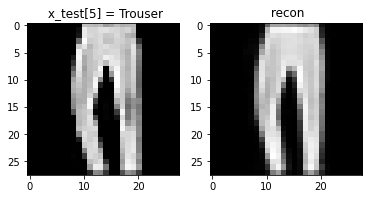

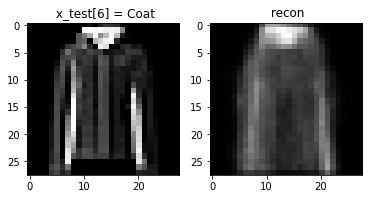

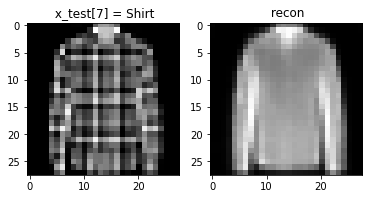

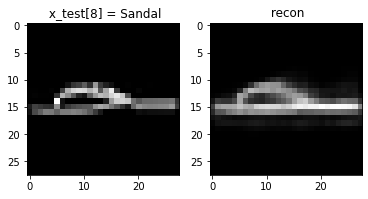

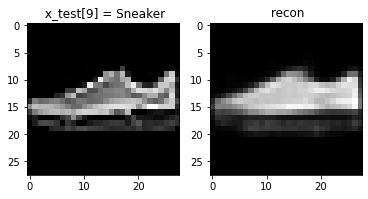

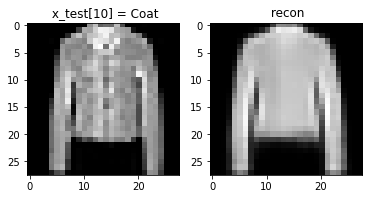

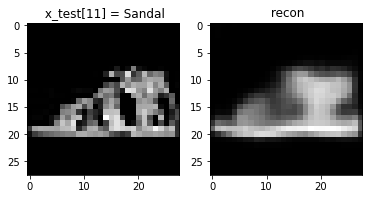

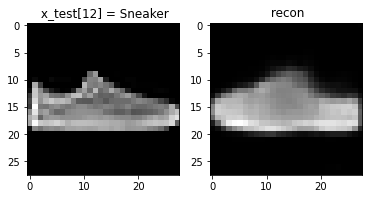

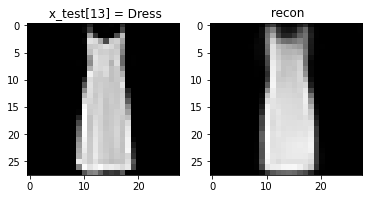

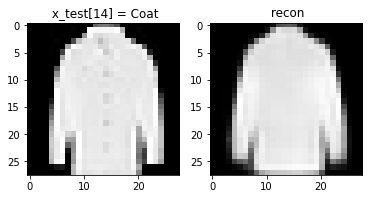

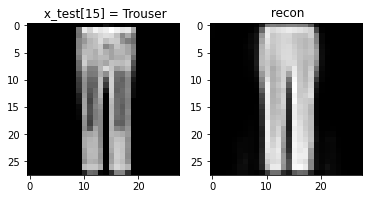

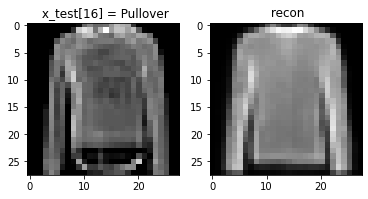

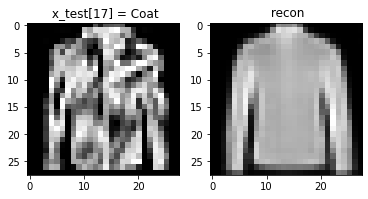

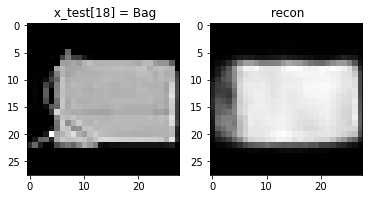

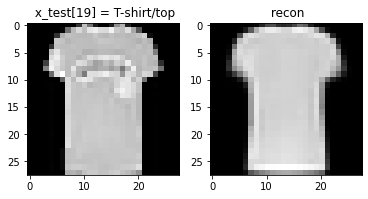

In [ ]:
n = 20
for i in range(n):
   x_recon = vae.predict( np.array( [x_test[i] ] ) )
   # First row is original x_test image
   plt.subplot(1,2,1).set_title( f" x_test[{i}] = {dicFashion[y_test[i]]}" )
   plt.imshow( x_test[i].reshape(28,28), cmap=plt.get_cmap('gray') )
   # Second row is the reconstructed image by auto encoder
   plt.subplot(1,2,2).set_title( f" recon" )
   plt.imshow( x_recon.reshape(28, 28), cmap=plt.get_cmap('gray') )
   plt.show()

##>> Latent Visualization 

In [ ]:
z_mean, _, _ = encoder.predict(x_train)
print(f"z_mean : {z_mean.shape}")

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


z_mean : (60000, 100)


In [ ]:
from sklearn.decomposition import PCA
pca2dim = PCA(n_components=2).fit(z_mean)
plot2d = pca2dim.transform(z_mean)

In [ ]:
cmap = plt.get_cmap('Paired', np.max(y_train) - np.min(y_train)+1)

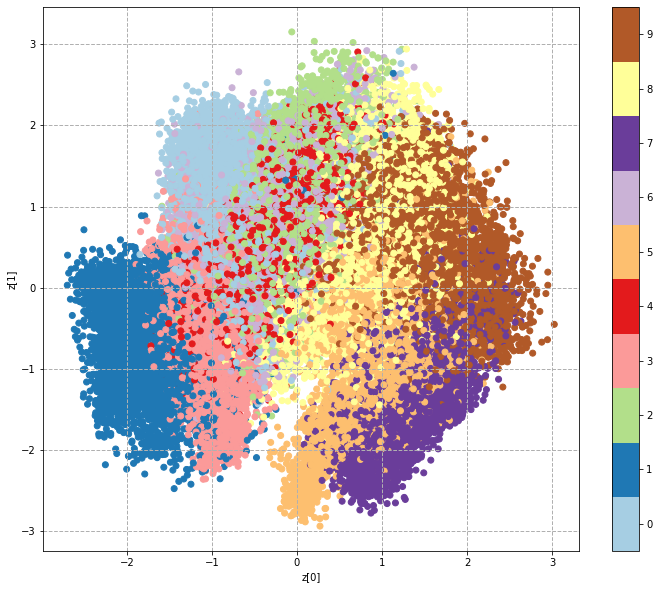

In [ ]:
plt.figure( figsize=(12,10))
plt.grid(b=True, which='major', axis='both', linestyle='--', linewidth=1)
plt.scatter( plot2d[:,0], plot2d[:,1], c=y_train, cmap=cmap
            , vmin=np.min(y_train)-.5
            , vmax=np.max(y_train)+.5)
plt.colorbar( ticks=np.arange( np.min(y_train), np.max(y_train)+1 ))
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

##>> Generate new image from grid value x,y

In [ ]:
def plot_latent_space( model, n=50, figsize=25 ):
  """ Code from https://keras.io/examples/generative/vae/ """
  # Displaya n*n 2D manifold of digits
  digit_size = 28
  scale = 3.0
  figure = np.zeros( (digit_size* n, digit_size*n ) )

  #Linearly aspaed coordiates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace( -scale, scale, n)
  grid_y = np.linspace( -scale, scale, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xj in enumerate(grid_x):
      z_sample = pca2dim.inverse_transform([xj,yi]).reshape(1,100)
      x_decoded = model.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size,digit_size)
      figure[ i*digit_size : (i+1) * digit_size,
              j*digit_size : (j+1) * digit_size,] = digit
  plt.figure(figsize=(figsize,figsize))
  start_range = digit_size//2
  end_range = n * digit_size + start_range
  pixel_range = np.arange( start_range, end_range, end_range)
  sample_range_x = np.round( grid_x, 1)
  sample_range_y = np.round( grid_y, 1)
  plt.xticks( pixel_range, sample_range_x)
  plt.yticks( pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap="Greys_r")
  plt.show()

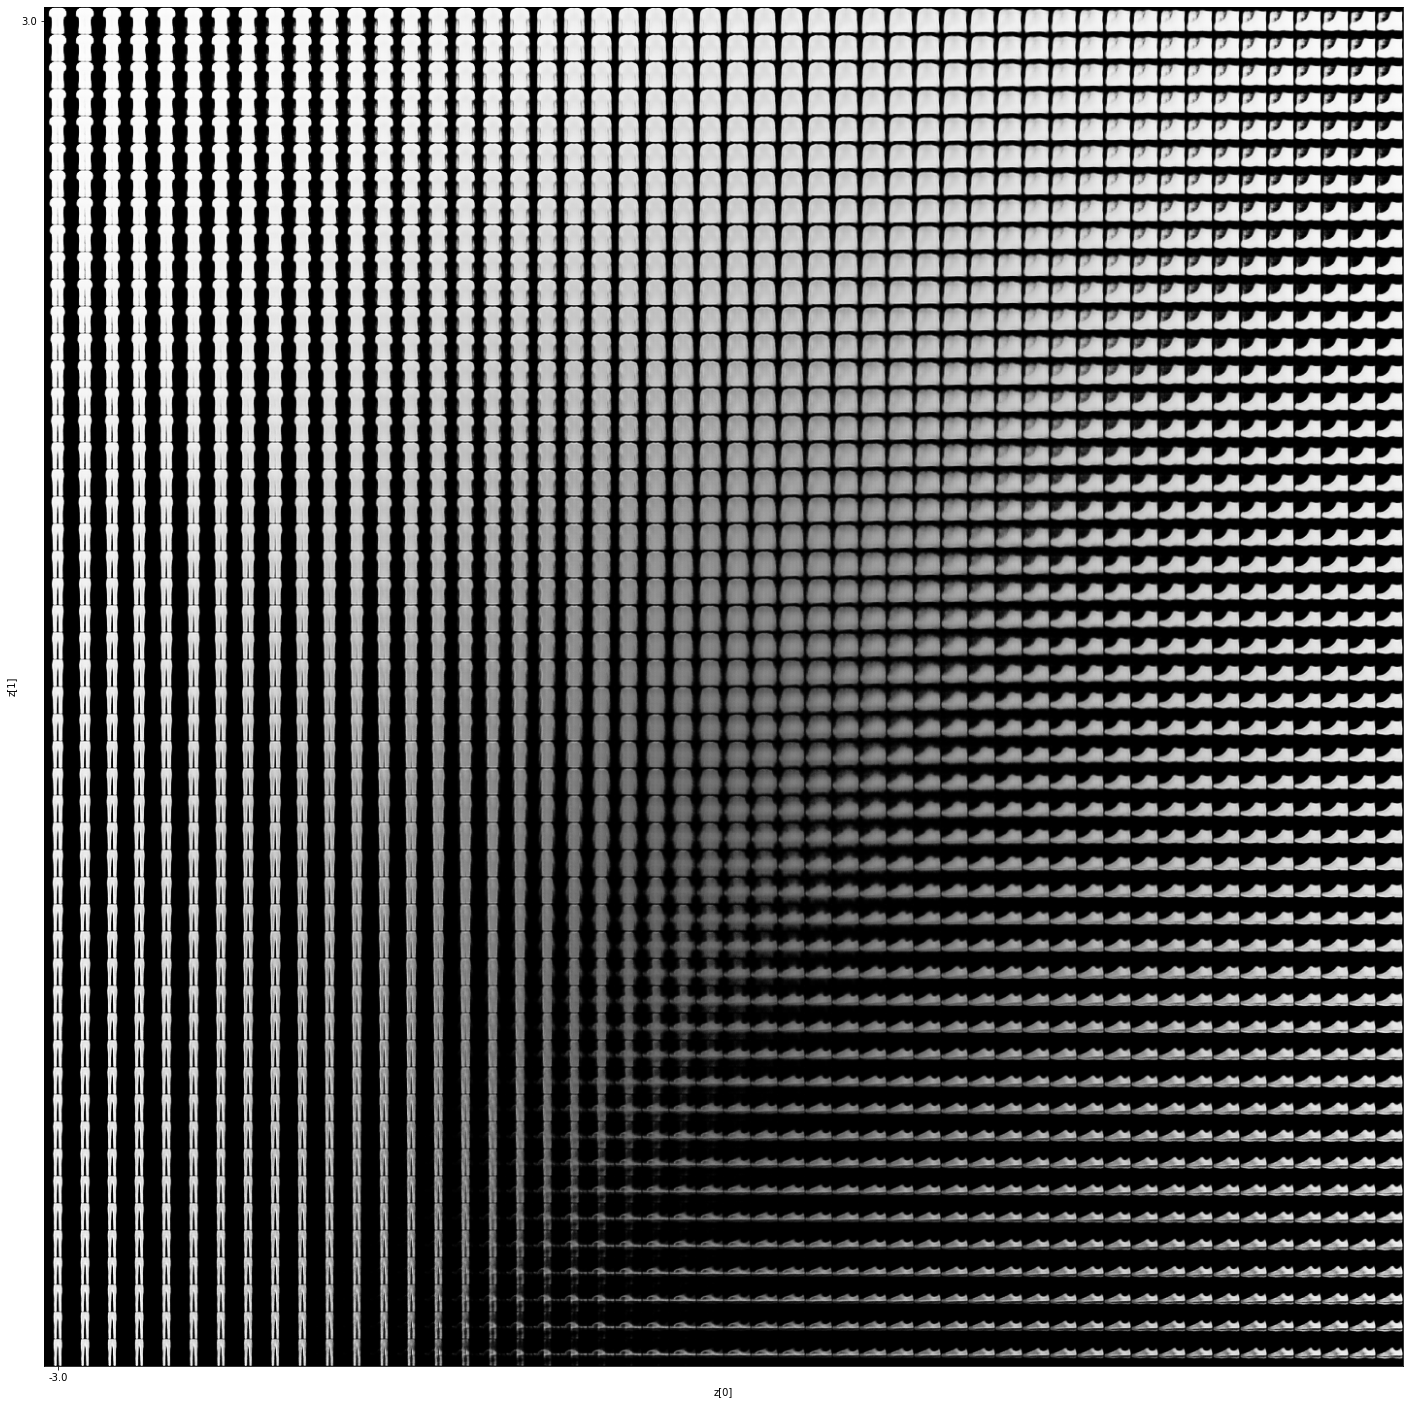

In [ ]:
plot_latent_space(decoder)

# 6 Generate New Image from random values

In [ ]:
decoder.predict(pca2dim.inverse_transform([-1,1]).reshape(1,100)).shape

(1, 28, 28, 1)

In [ ]:
np.random.uniform(-1.00,-0.75, (1,latent_dim)).astype(np.float32)

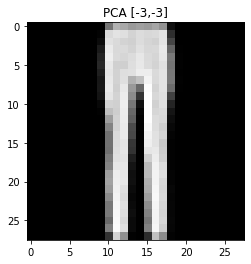

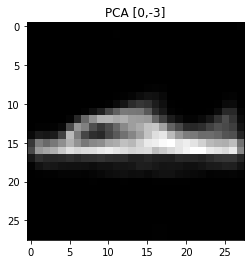

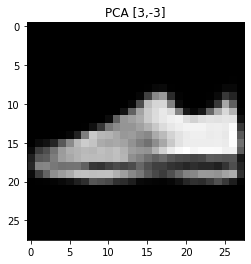

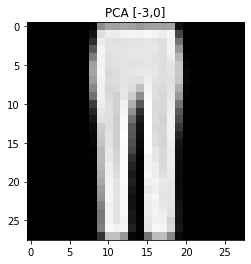

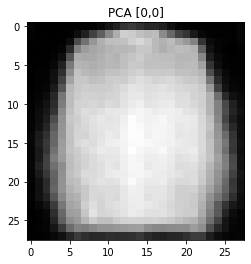

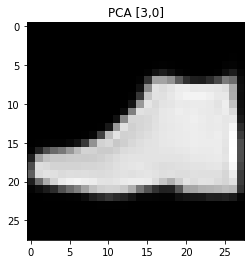

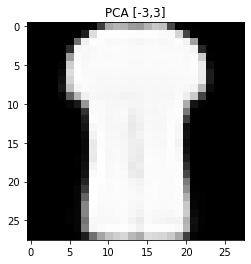

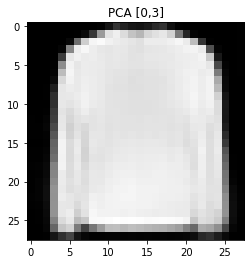

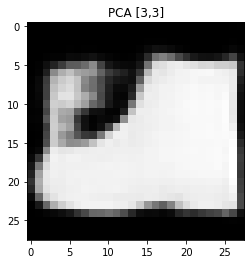

In [ ]:
lst_generate = [ [-3,-3],[0,-3],[3,-3],[-3,0],[0,0],[3,0],[-3,3],[0,3],[3,3]]
for gen in lst_generate:
   z_simple = pca2dim.inverse_transform([gen[0],gen[1]]).reshape(1,100)
   gen_img = decoder.predict(z_simple)[0].reshape(28,28)
   plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
   plt.title(f'PCA [{gen[0]},{gen[1]}]')
   plt.xlabel("")
   plt.ylabel("")
   plt.show()

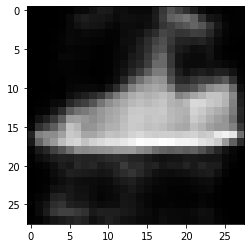

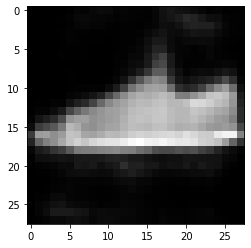

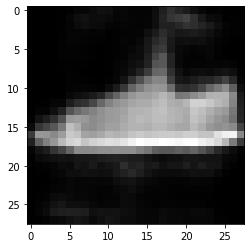

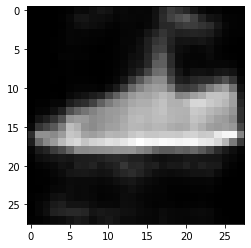

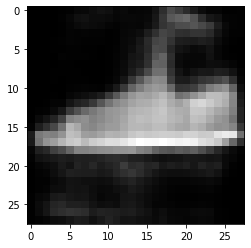

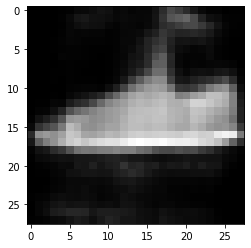

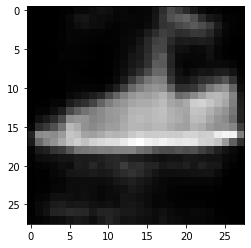

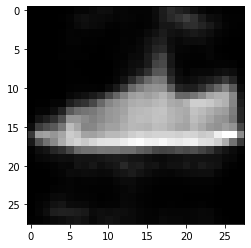

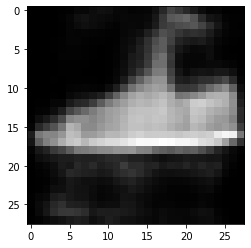

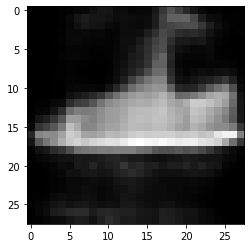

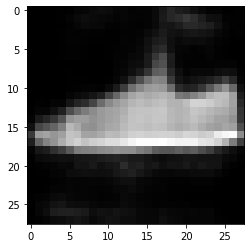

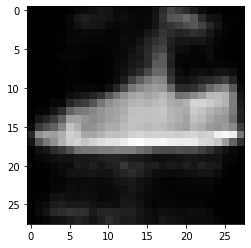

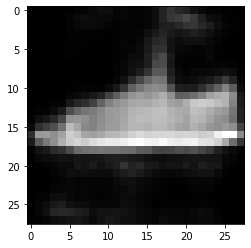

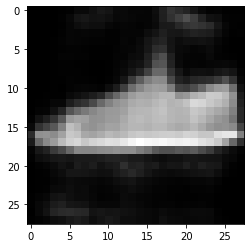

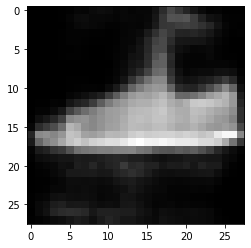

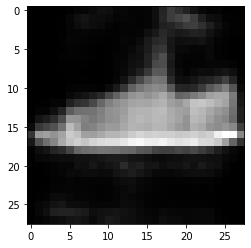

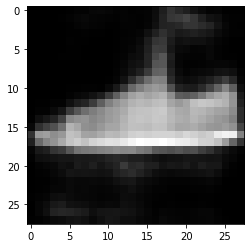

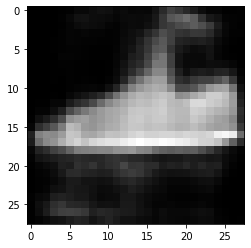

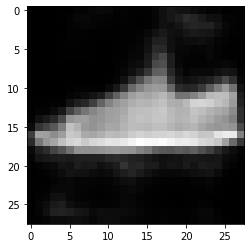

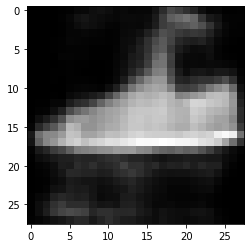

In [ ]:
for i in range(20):
  random_num = np.random.uniform(-1.00,-0.75, (1,latent_dim)).astype(np.float32)
  gen_img = decoder.predict(random_num)[0].reshape(28,28)
  plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
  plt.show()

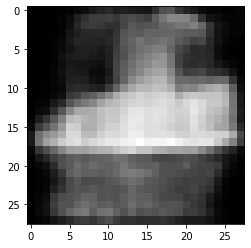

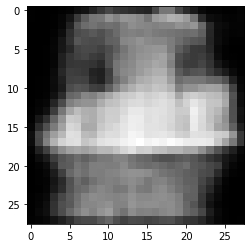

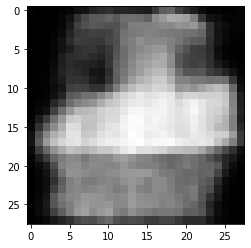

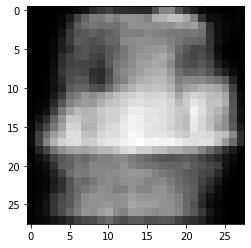

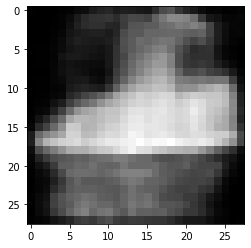

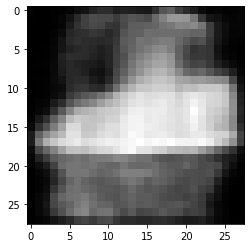

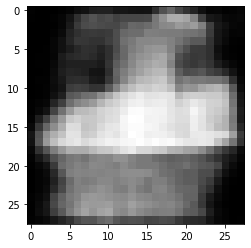

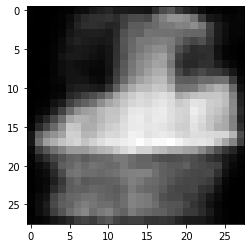

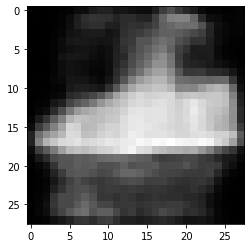

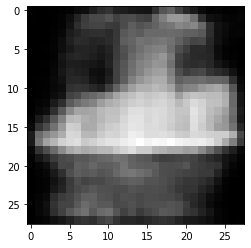

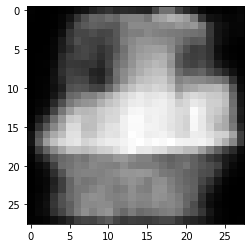

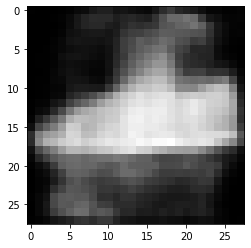

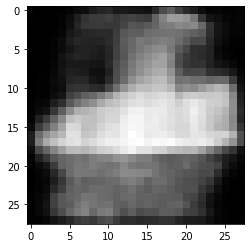

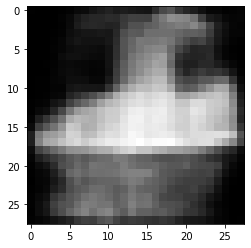

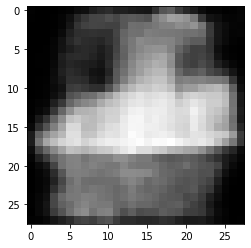

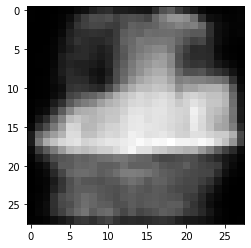

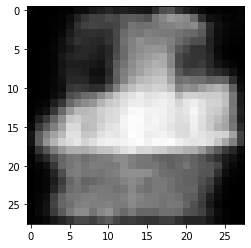

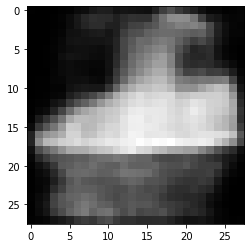

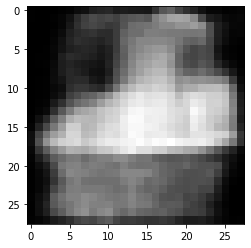

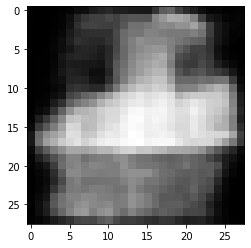

In [ ]:
for i in range(20):
  random_num = np.random.uniform(-0.75,-0.50, (1,latent_dim)).astype(np.float32)
  gen_img = decoder.predict(random_num)[0].reshape(28,28)
  plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
  plt.show()

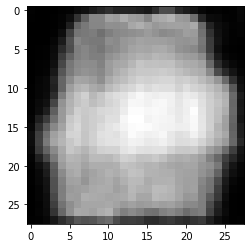

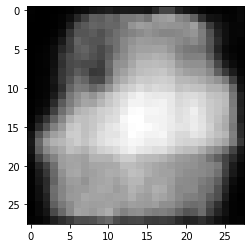

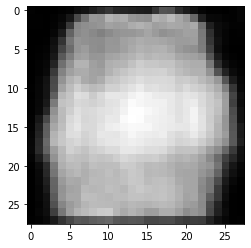

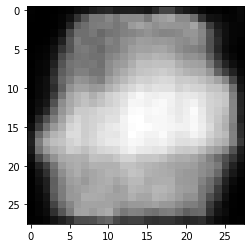

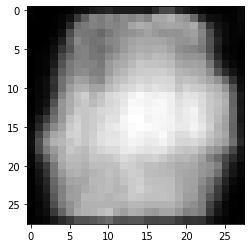

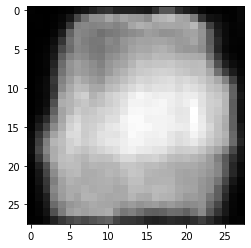

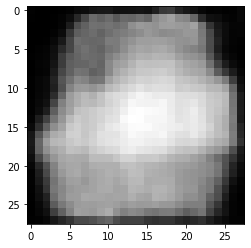

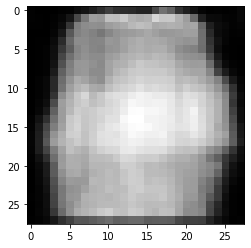

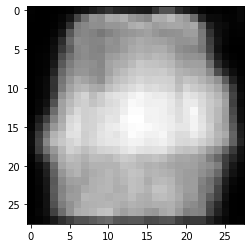

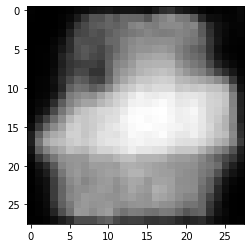

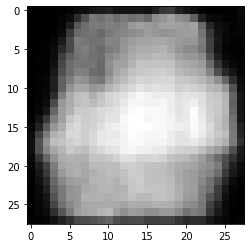

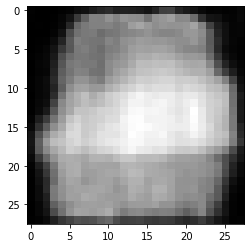

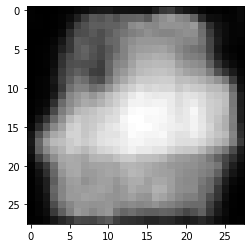

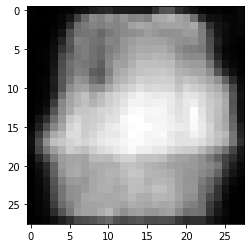

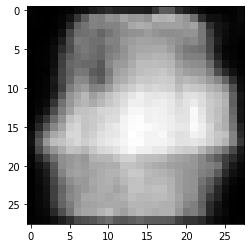

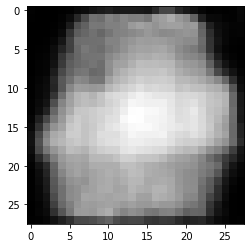

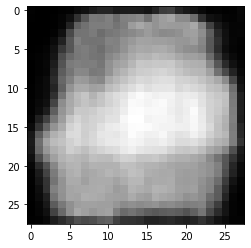

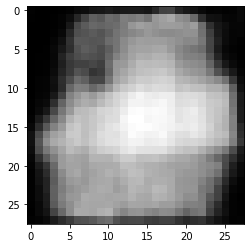

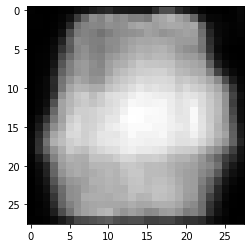

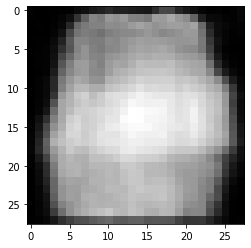

In [ ]:
for i in range(20):
  random_num = np.random.uniform(-0.50,-0.25, (1,latent_dim)).astype(np.float32)
  gen_img = decoder.predict(random_num)[0].reshape(28,28)
  plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
  plt.show()

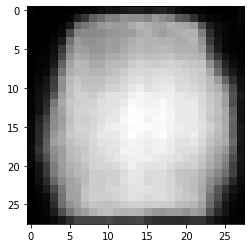

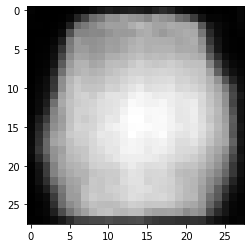

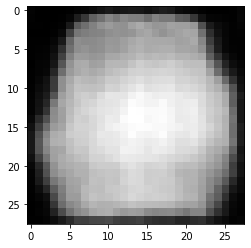

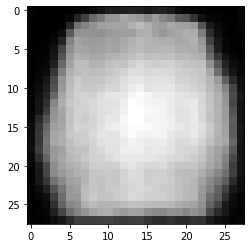

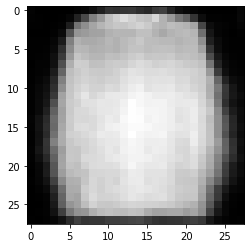

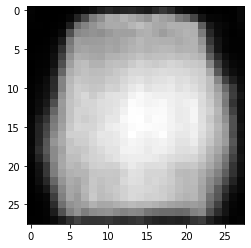

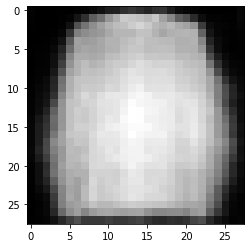

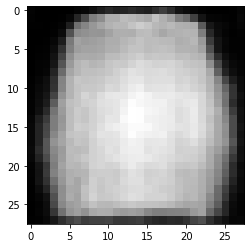

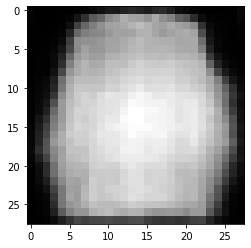

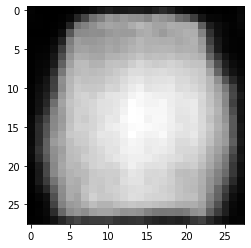

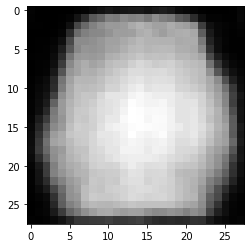

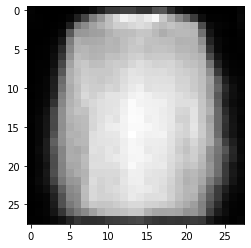

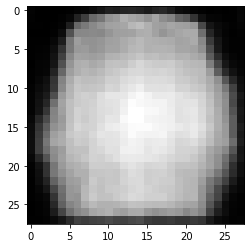

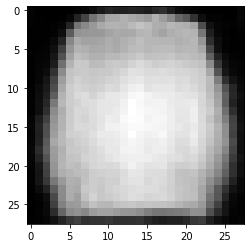

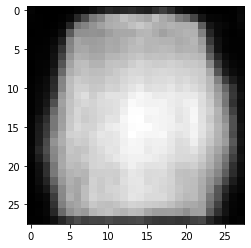

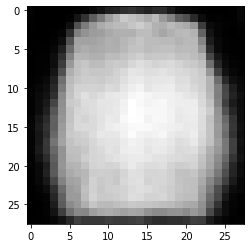

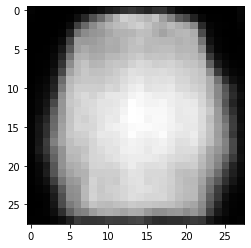

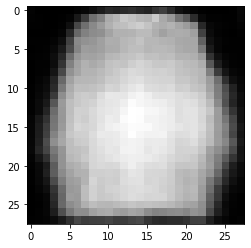

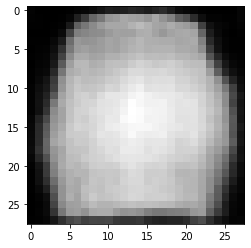

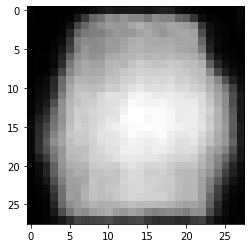

In [ ]:
for i in range(20):
  random_num = np.random.uniform(-0.25,0.00, (1,latent_dim)).astype(np.float32)
  gen_img = decoder.predict(random_num)[0].reshape(28,28)
  plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
  plt.show()

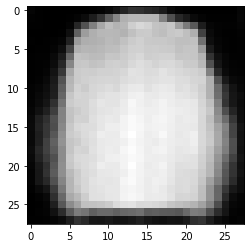

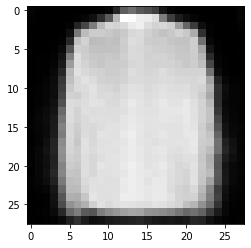

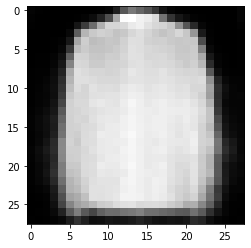

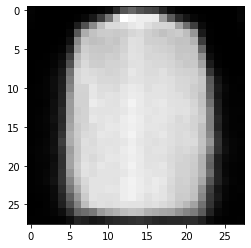

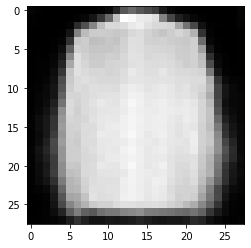

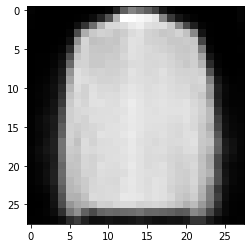

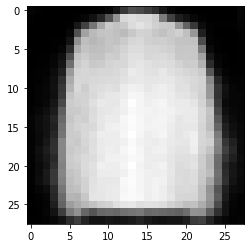

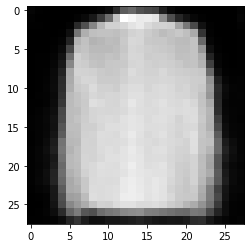

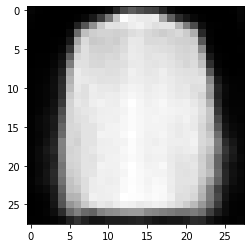

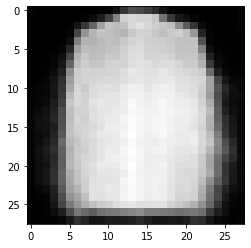

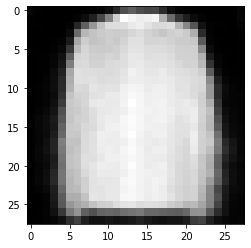

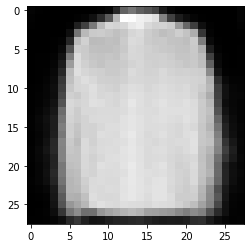

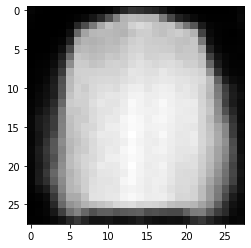

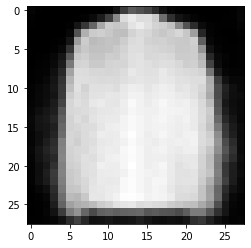

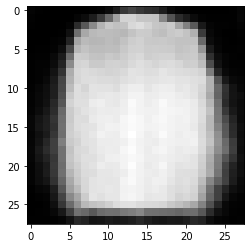

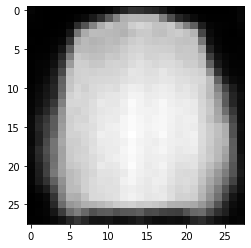

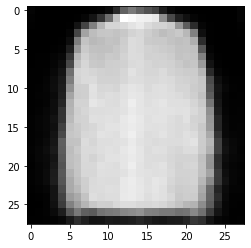

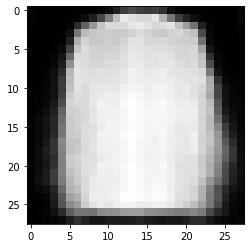

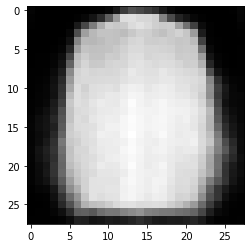

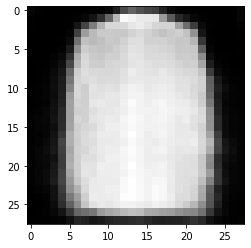

In [ ]:
for i in range(20):
  random_num = np.random.uniform(0.00,0.25, (1,latent_dim)).astype(np.float32)
  gen_img = decoder.predict(random_num)[0].reshape(28,28)
  plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
  plt.show()

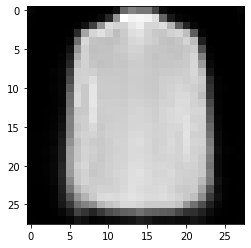

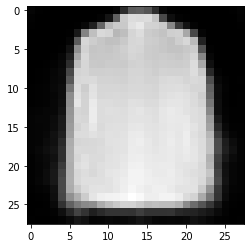

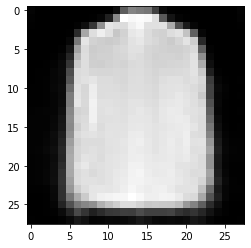

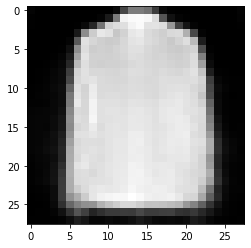

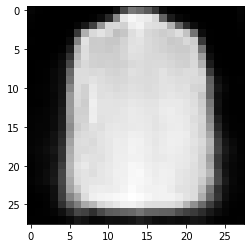

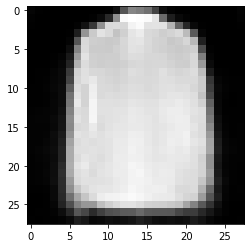

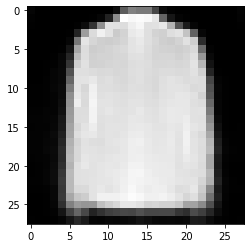

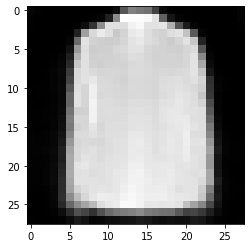

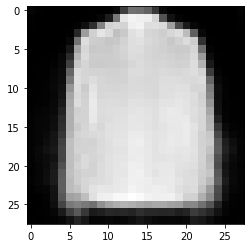

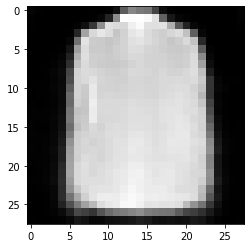

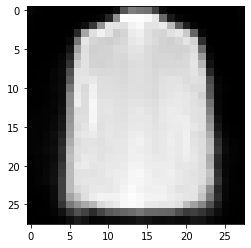

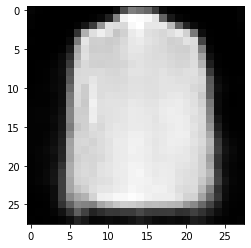

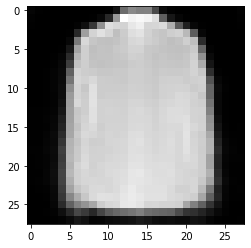

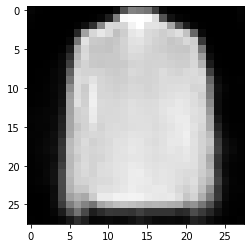

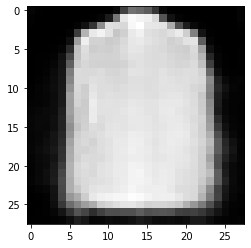

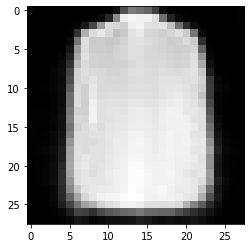

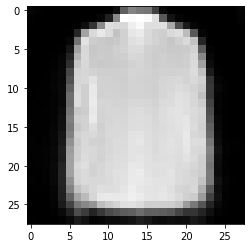

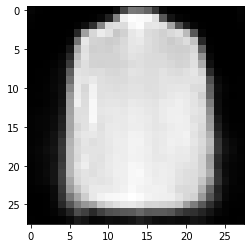

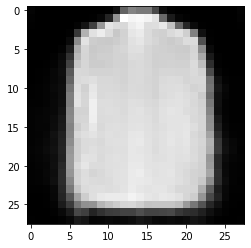

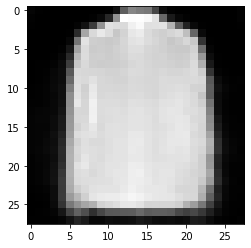

In [ ]:
for i in range(20):
  random_num = np.random.uniform(0.25,0.50, (1,latent_dim)).astype(np.float32)
  gen_img = decoder.predict(random_num)[0].reshape(28,28)
  plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
  plt.show()

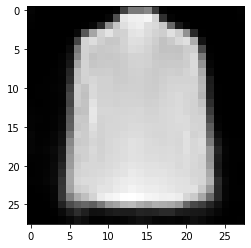

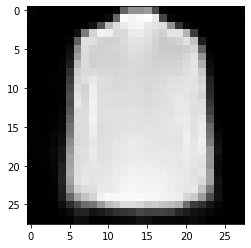

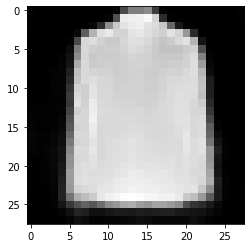

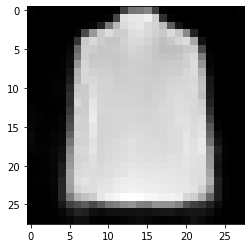

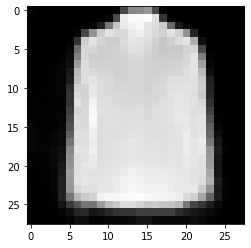

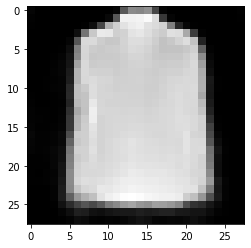

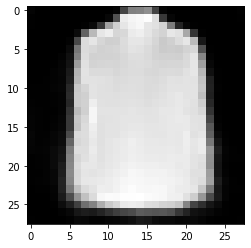

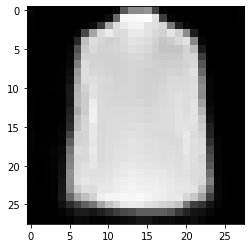

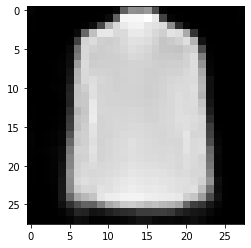

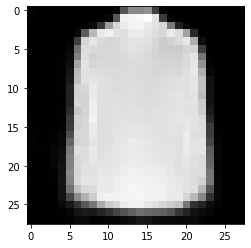

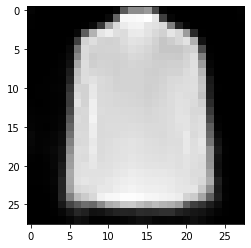

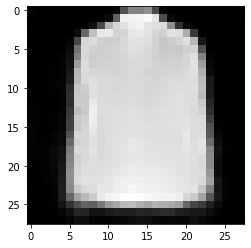

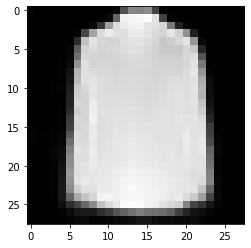

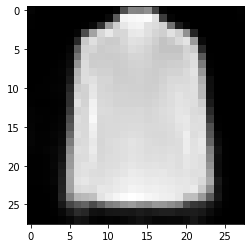

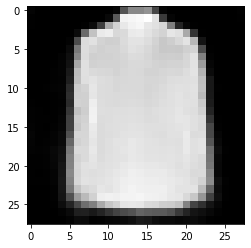

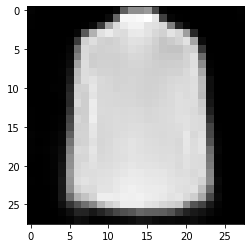

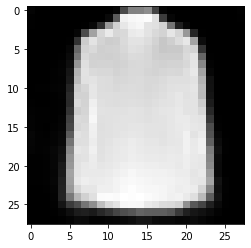

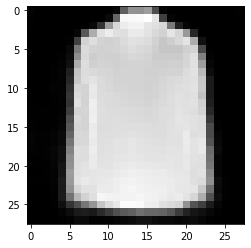

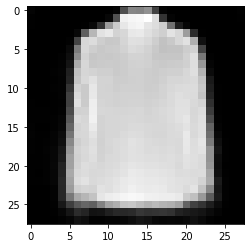

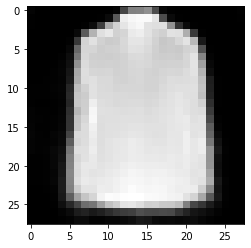

In [ ]:
for i in range(20):
  random_num = np.random.uniform(0.50,0.75, (1,latent_dim)).astype(np.float32)
  gen_img = decoder.predict(random_num)[0].reshape(28,28)
  plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
  plt.show()

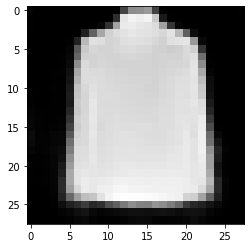

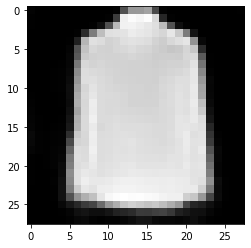

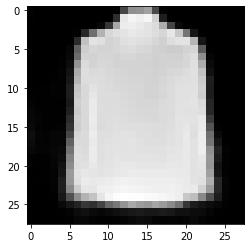

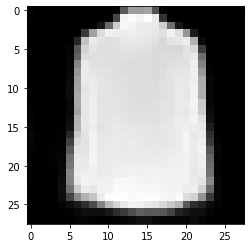

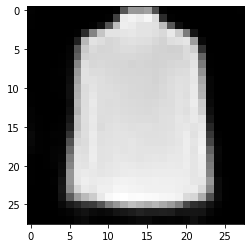

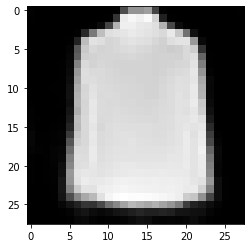

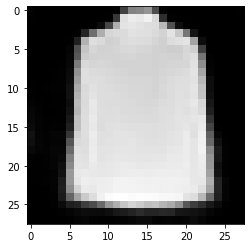

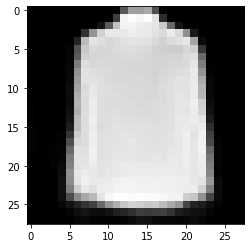

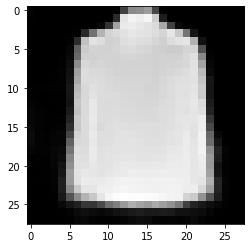

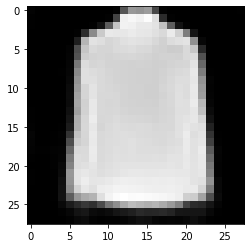

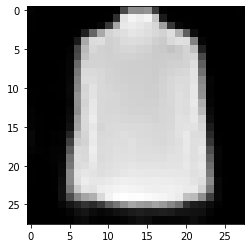

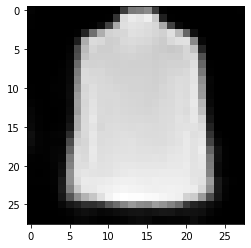

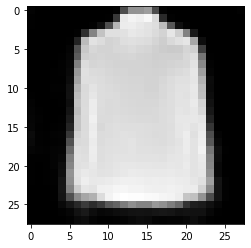

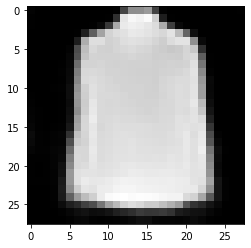

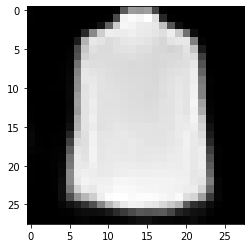

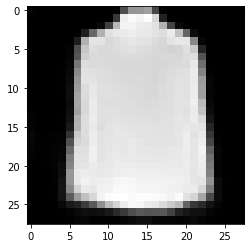

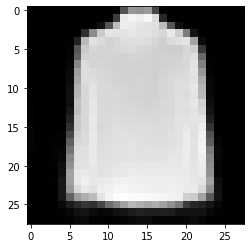

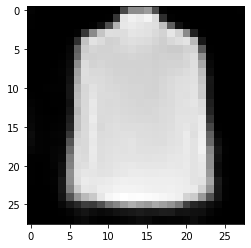

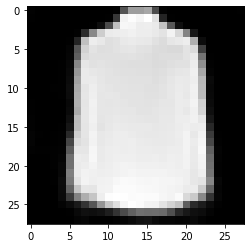

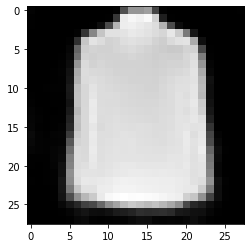

In [ ]:
for i in range(20):
  random_num = np.random.uniform(0.75,1.00, (1,latent_dim)).astype(np.float32)
  gen_img = decoder.predict(random_num)[0].reshape(28,28)
  plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
  plt.show()

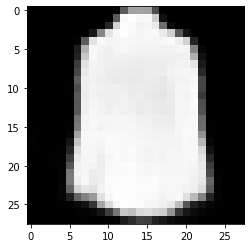

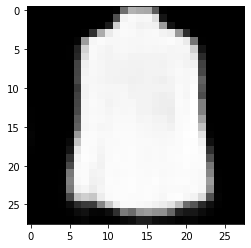

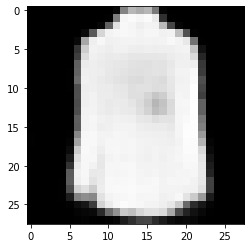

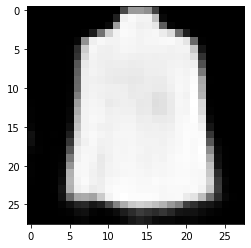

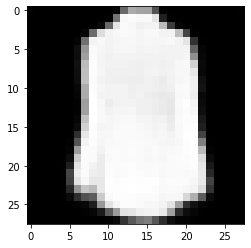

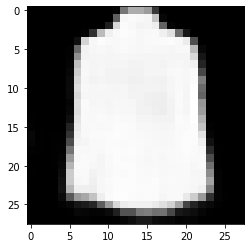

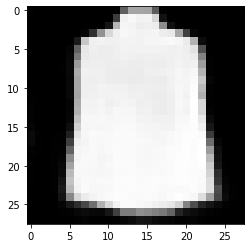

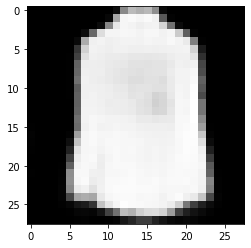

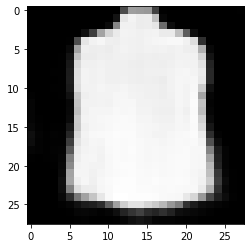

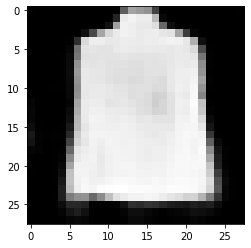

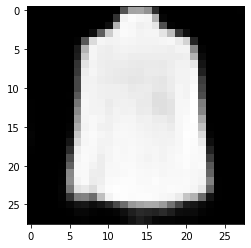

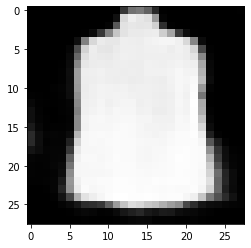

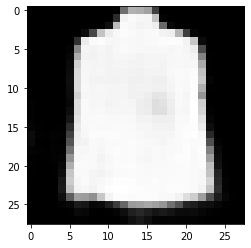

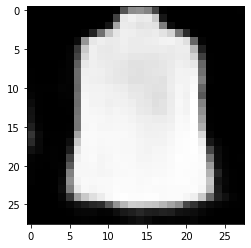

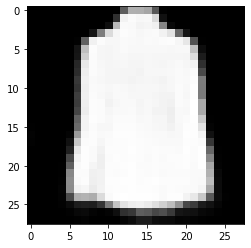

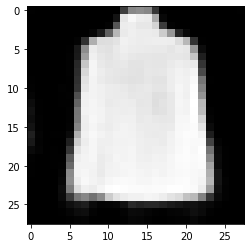

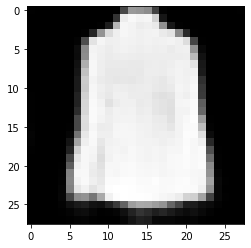

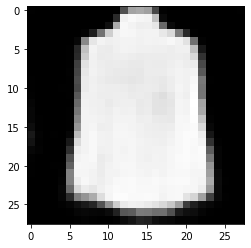

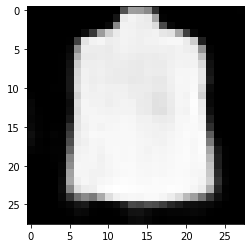

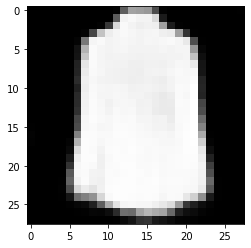

In [ ]:
for i in range(20):
  random_num = np.random.uniform(1.00,2.00, (1,latent_dim)).astype(np.float32)
  gen_img = decoder.predict(random_num)[0].reshape(28,28)
  plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
  plt.show()

In [ ]:
for i in range(20):
  random_num = np.random.uniform(0.75,1.00, (1,latent_dim)).astype(np.float32)
  gen_img = decoder.predict(random_num)[0].reshape(28,28)
  plt.imshow( gen_img, cmap=plt.get_cmap('gray') )
  plt.show()